### Generate tomo_file.xyz and run 2D forward simulation 
by Andrea R.  
Using Checkboard Example - Specfem2D workshop (by Bryant Chow)

This notebook shows an example of how to create a tomofile, using the velocity model of an example available in the EXAMPLE folder of specfem2d. 

The structure of the tomofile is the following:   
The header of the 'tomo.xyz' file shoud have the following information.  

```
x_min z_min x_max z_max
x_spacing z_spacing
nx nz
vp_min vp_max vs_min vs_max rho_min rho_max
```

Then we have to give the x z vp vs and rho values for each grid point in the tomographic model.


In the Par_file you have to define the following.
Under # velocity and density models, define your model as follows
```
1 -1 0 0 0.5 0 0 0 0 0 0 0 0 0 0
```

Then you have to set the tomo.xyz file path. Make sure you give the right path (I guess it should be relative to the DATA folder).
```
TOMOGRAPHY_FILE                 = tomo.xyz
```

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import FunctionsPlotBin
import sys
import IPython.display as dp

from scipy.interpolate import griddata
from PIL import Image

In [2]:
def plot_checkerboard(x, z, c, label, alpha=1):
    """Simple re-usable model plotting function"""
    plt.tricontourf(x, z, c, levels=125, cmap="seismic_r", alpha=alpha)
    plt.xlabel("X, m")
    plt.ylabel("Z, m")
    plt.title("Checkerboard Model")
    plt.colorbar(label=label)

(0.0, 50000.0)

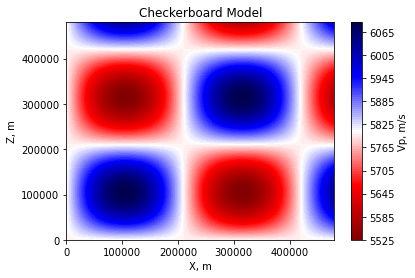

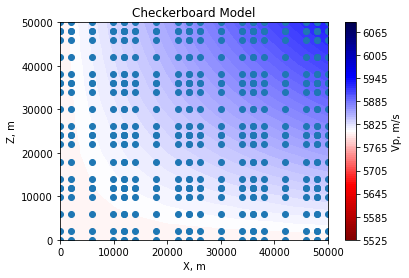

In [3]:
# We are going to use the material properties from the checkboard example - Tape et al. 2007
# Values of X, Z, Vs and Vp for plotting 
chkbd_x, chkbd_z, chkbd_rho, chkbd_vp, chkbd_vs = np.genfromtxt("Examples/DATA_Example02/model_velocity.dat_checker", dtype=float, usecols=[1,2,3,4,5]).T

# Let's plot the Vp data 
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp, m/s")

# Now let's see how data is organized in the .dat file 
# Data available in .dat file is given on the GLLs (non-regular mesh, distance between GLLs is not regular)
plt.figure()
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp, m/s")
plt.scatter(chkbd_x,chkbd_z)
plt.xlim(0, 50000)
plt.ylim(0, 50000)

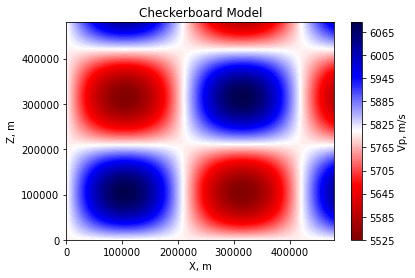

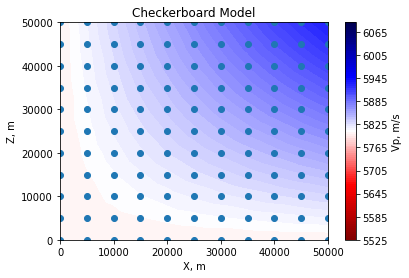

In [4]:
# Generate tomography file for SPECFEM2D

# We need to generate a tomography file from model_velocity.dat_checker, the tomography file will 
# store data points for a REGULAR mesh.

# Simulation domain data 
x_min=np.min(chkbd_x)
x_max=np.max(chkbd_x)
z_min=np.min(chkbd_z)
z_max=np.max(chkbd_z)

# Target regular mesh to interpolate to
dx = dz= 5000 
xg = np.arange(0,x_max+dx,dx)
zg = np.arange(0,z_max+dz,dz)
xg,zg = np.meshgrid(xg,zg)

# Interpolate
chkbd_rho_rg = griddata((chkbd_x,chkbd_z),chkbd_rho,(xg,zg),method='linear')
chkbd_vp_rg = griddata((chkbd_x,chkbd_z),chkbd_vp,(xg,zg),method='linear')
chkbd_vs_rg = griddata((chkbd_x,chkbd_z),chkbd_vs,(xg,zg),method='linear')

# Matrix to vector 
chkbd_rho_rgv=chkbd_rho_rg.flatten()
chkbd_vp_rgv=chkbd_vp_rg.flatten()
chkbd_vs_rgv=chkbd_vs_rg.flatten()
xgv=xg.flatten()
zgv=zg.flatten()
nx=len(xg)
nz=len(zg)

# Plot checkboard after generating regular mesh
plot_checkerboard(xgv, zgv, chkbd_vp_rgv, label="Vp, m/s")

# Now let's see how the regulat mesh looks like 
plt.figure()
plot_checkerboard(xgv, zgv, chkbd_vp_rgv, label="Vp, m/s")
plt.scatter(xgv,zgv)
plt.xlim(0, 50000)
plt.ylim(0, 50000)

# ---------------------------------------------------------------------
# Print tomography file 
# ---------------------------------------------------------------------
fileID=open('tomo_file.xyz','w')

# Header lines
L1 = format(int(x_min), '10d') + ' ' + format(int(z_min), '10d') + ' ' + format(int(x_max), '10d') + ' ' + format(int(z_max), '10d')
L2 = format(int(dx), '10d') + ' ' + format(int(dz), '10d') 
L3 = format(int(nx), '10d') + ' ' + format(int(nz), '10d') 
L4 = format(int(np.min(chkbd_vp_rgv)), '10d') + ' ' + format(int(np.max(chkbd_vp_rgv)), '10d') + ' ' + format(int(np.min(chkbd_vs_rgv)), '10d') + ' ' + format(int(np.max(chkbd_vs_rgv)), '10d') + ' ' + format(int(np.min(chkbd_rho_rgv)), '10d') + ' ' + format(int(np.max(chkbd_rho_rgv)), '10d')
Header=[L1+ "\n",L2+ "\n",L3+ "\n",L4+ "\n"]
fileID.writelines(Header)

# Material model lines
for i in np.arange(0,nx*nz):
    Li= format(int(xgv[i]), '10d') + ' ' + format(int(zgv[i]), '10d')+ ' ' + format(int(chkbd_vp_rgv[i]), '10d')+ ' ' + format(int(chkbd_vs_rgv[i]), '10d')+ ' ' + format(int(chkbd_rho_rgv[i]), '10d') + "\n" 
    fileID.writelines(Li)
fileID.close()


### Run the simulation in specfem2d

In [5]:
specfem2d_path = "/Users/andreacamilarianoescandon/packages"
EXAMPLE = os.path.join(os.getcwd(),"Examples", "DATA_Example02")
WORKDIR = os.path.join(os.getcwd(),"work")

# In case we've run this docs page before, delete the working directory before remaking
if os.path.exists(WORKDIR):
    shutil.rmtree(WORKDIR)

In [6]:
# Distribute the necessary file structure of the SPECFEM2D repository that we will download/reference
SPECFEM2D_ORIGINAL = os.path.join(specfem2d_path, "specfem2d") 
SPECFEM2D_BIN_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "bin")
SPECFEM2D_DATA_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "DATA")

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "ExampleTomofile")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")

# Pre-defined locations of velocity models we will generate using the solver
SPECFEM2D_MODEL_INIT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_INIT")
SPECFEM2D_MODEL_TRUE = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_TRUE")

In [7]:
# Copy the binary files incase we update the source code. These can also be symlinked.
shutil.copytree(SPECFEM2D_BIN_ORIGINAL, SPECFEM2D_BIN)

# Copy the DATA/ directory 
shutil.copytree(EXAMPLE, SPECFEM2D_DATA)

# Move tomo_file.xyz to SPECFEM2D_DATA folder
shutil.move('tomo_file.xyz',SPECFEM2D_DATA)
!ls

A_InstallingSpecfem2d.ipynb FunctionsPlotBin.py
B_Specfem2D_Example.ipynb   README.md
C_Specfem2D_Tomofile.ipynb  UtilityFunctions.py
D_Specfem2D_Kernel.ipynb    __pycache__
Examples                    work


In [13]:
# create the OUTPUT_FILES directory before running 
os.chdir(SPECFEM2D_WORKDIR)
if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)

# run mesher and solver
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt
print("Completed - Check results in OUTPUT_FILES directory")

Completed - Check results in OUTPUT_FILES directory
